# Understanding details about how Langosco et al.'s nets work
Let's understand lots of details about [the goal misgeneralization paper](). In particular, we'll be looking at the cheese-maze task from the goal misgeneralization task, for which cheese was spawned in the 5x5 top-right corner of the maze. 

Key conclusions:
1. Convolutional layers limit speed of information propagation (_locality_). More precisely, any portions of the state separated by `n` pixels take **??** convolutional layers to interact.
2. In the maximal maze size of **??**, there is at most two steps of computation involving information from e.g. opposite corners of the maze. 

In [1]:
# %% Don't have to restart kernel and reimport each time you modify a dependency
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable
import re 

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output
from ipywidgets import Text, interact, IntSlider, fixed, FloatSlider, Dropdown
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

# NOTE: this is Monte's RL hooking code (and other stuff will be added in the future)
# Install normally with: pip install circrl
import circrl.module_hook as cmh
import procgen_tools.models as models
from experiments.patch_utils import *

# %% 
# Load two levels and get values
import pickle as pkl
from procgen import ProcgenGym3Env

rand_region = 5
# Check whether we're in jupyter
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False
path_prefix = '../' if in_jupyter else ''

# %%
# Load model

policy = models.load_policy(path_prefix + f'trained_models/maze_I/model_rand_region_{rand_region}.pth', 15,
    t.device('cpu'))

# %% Experiment parameters
label = 'embedder.block2.res1.resadd_out'
interesting_coeffs = np.linspace(-2/3,2/3,10) 
hook = cmh.ModuleHook(policy)

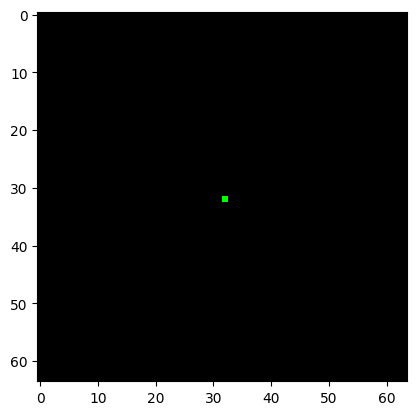

In [39]:
# Let's load a dummy observation with only one nonzero value
# This is the same as the one used in rollout-patch.py
dummy_obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
dummy_obs[0, 1, 32,32] = 1 # Have one pixel in the middle, in the "red" channel

# Show dummy_obs as an RGB image
plt.imshow(dummy_obs[0].transpose(1,2,0))

In [ ]:
# Let's visualize the convolution activations at each layer. First we have to get the relevant layers
hook.probe_with_input(dummy_obs)
labels = list(hook.values_by_label.keys()) 
# Use regex to check whether the label contains 'conv' and 'out', with an optional number in between
conv_labels = [l for l in labels if re.match(r'.*conv.*out.*', l)]
print(conv_labels)

In [36]:
# Now that we have the conv labels, let's visualize the activations at each one using plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def plot_conv_activations(label: str, channel: int):
    activations = hook.get_value_by_label(label)
    activations = rearrange(activations, 'b c h w -> b h w c')
    assert channel < activations.shape[-1], "Channel doesn't exist at this layer"
    diff_activations = activations[1] - activations[0] # Subtract in order to cancel out bias terms which don't behave differently in the presence of our 1/0 discrepancy on the dummy input

    fig = go.Figure(data=go.Heatmap(z=diff_activations[channel]))
    fig.update_layout(height=500, width=500, title_text=label)
    fig.show()

interact(plot_conv_activations, label=Dropdown(options=conv_labels), channel=IntSlider(min=0, max=128, step=1, value=0))

interactive(children=(Dropdown(description='label', options=('embedder.block1.conv_out', 'embedder.block1.res1…

<function __main__.plot_conv_activations(label: str, channel: int)>